Two things covered here:

**A. Estimating model Generalization Error for CV**

**B. Cross Validation for Hyper Parameter Tunning**

## A.Estimating model Generalization Error for CV

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import comb

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    LeaveOneOut,
    LeavePOut,
    StratifiedKFold,
    GridSearchCV,
    cross_validate,
    train_test_split
)


In [2]:
# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# percentage of benign (0) and malign tumors (1)
y.value_counts(normalize=True)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## 1. K-Fold Cross-Validation

In [13]:
# Logistic Regression
logit = LogisticRegression(penalty='l2', C=10, solver='liblinear', random_state=4, max_iter=10000) #l2=lasso penalty

# K-Fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# Search
clf = cross_validate(
    logit, 
    X_train,
    y_train,
    scoring='accuracy',
    return_train_score=True,
    cv=kf, #k-fold
)

clf['test_score'] #clf is effectively a dictionary, try printing it out

array([0.925     , 0.95      , 0.9625    , 0.96202532, 0.94936709])

In [14]:
# to verify that clf is a dictionary
clf

{'fit_time': array([0.00653386, 0.00574684, 0.00640607, 0.00534797, 0.00552773]),
 'score_time': array([0.00250006, 0.0020802 , 0.00177789, 0.00138307, 0.00148821]),
 'test_score': array([0.925     , 0.95      , 0.9625    , 0.96202532, 0.94936709]),
 'train_score': array([0.97484277, 0.96540881, 0.96855346, 0.96238245, 0.97178683])}

In [15]:
# what was the accuracy in the left out dataset
clf.get('train_score')

array([0.97484277, 0.96540881, 0.96855346, 0.96238245, 0.97178683])

In [32]:
train_acc = np.mean(clf['train_score'])
test_acc = np.mean(clf['test_score'])
print(f'mean train set accuracy: {acc :.4f}')
print(f'mean test set accuracy: {test_acc :.4f}')

mean train set accuracy: 0.9686
mean test set accuracy: 0.9498


In [35]:
print('mean train set accuracy: {:.4f} +- {:.6f}'.format(np.mean(clf['train_score']), np.std(clf['train_score'])))
print('mean test set accuracy: {:.4f} +- {:.6f}'.format(np.mean(clf['test_score']), np.std(clf['test_score'])))

mean train set accuracy: 0.9686 +- 0.004427
mean test set accuracy: 0.9498 +- 0.013609


Notice:
- train set accuracy is 96 +- a number in the third decimal
- test set accuracy is 94 +- a number in the second decimal. We can see that if we add 1 (roughly the error) to the accuracy here, we are within the train set accuracy meaning there's no overfitting
- We can expect the performance of our test set (not the test set to be within the test set accuracy)

## 2. Repeated K-Fold

In [40]:
# Logistic Regression
logit = LogisticRegression(
    penalty='l2', C=1, solver='liblinear', random_state=4, max_iter=10000)

# Repeated K-Fold Cross Validation
rkf = RepeatedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=4
)

print('We expect k * n performance metrics: ', 5*10)

# search
clf = cross_validate(
    logit,
    X_train,
    y_train,
    scoring='accuracy',
    return_train_score=True,
    cv=rkf
)

print('Number of metrics obtained: {}'.format(len(clf['test_score'])))

clf['test_score']

We expect k * n performance metrics:  50
Number of metrics obtained: 50


array([0.9       , 0.9375    , 0.975     , 0.96202532, 0.94936709,
       0.9625    , 0.9625    , 0.9125    , 0.96202532, 0.92405063,
       0.9875    , 0.95      , 0.975     , 0.91139241, 0.96202532,
       0.95      , 0.9375    , 0.95      , 0.92405063, 0.96202532,
       0.975     , 0.9125    , 0.9375    , 0.94936709, 0.96202532,
       0.9875    , 0.9125    , 0.9375    , 0.92405063, 0.96202532,
       0.9625    , 0.9375    , 0.95      , 0.92405063, 0.93670886,
       0.95      , 0.95      , 0.95      , 0.98734177, 0.88607595,
       0.95      , 0.925     , 0.9625    , 0.96202532, 0.94936709,
       0.925     , 0.9625    , 0.925     , 0.91139241, 0.96202532])

In [43]:
print('train set accuracy: {:.4f} +- {:.6f}'.format(np.mean(clf['train_score']), np.std(clf['train_score'])))
print('test set accuracy: {:.4f} +- {:.6f}'.format(np.mean(clf['test_score']), np.std(clf['test_score'])))

train set accuracy: 0.9603 +- 0.006710
test set accuracy: 0.9457 +- 0.022986


## 3. Leave One out

In [46]:
# Logistic Regression
logit = LogisticRegression(
    penalty='l2', C=1, solver='liblinear', random_state=4, max_iter=10000)

# Leave One Out cross validation
loo = LeaveOneOut()

print('We expect as many metrics as data in the train set: ', len(X_train))

# search
clf = cross_validate(
    logit,
    X_train,
    y_train,
    scoring='accuracy',
    return_train_score=True,
    cv=loo
)

print('Number of metrics obtained: {}'.format(len(clf['test_score'])))

len(clf['test_score'])

We expect as many metrics as data in the train set:  398
Number of metrics obtained: 398


398

In [47]:
print('train set accuracy: {:.4f} +- {:.6f}'.format(np.mean(clf['train_score']), np.std(clf['train_score'])))
print('test set accuracy: {:.4f} +- {:.6f}'.format(np.mean(clf['test_score']), np.std(clf['test_score'])))

train set accuracy: 0.9575 +- 0.001255
test set accuracy: 0.9447 +- 0.228519


Notice:
- The test accuracy error (0.228) is much bigger because we are measuring the performance on just one observation

## 4. Leave P Out

This cross validation procedure will leave out all possible combinations of 2 observation from the data implying it will train a lot of models

In [56]:
# Logistic Regression
logit = LogisticRegression(
    penalty='l2', C=1, solver='liblinear', random_state=4, max_iter=10000)

# Leave One Out cross validation
lpo = LeavePOut(p=2)

# Let's take a smaller sample of data to avoid computer running out of memory
X_train_small = X_train.head(100)
y_train_small = y_train.head(100)

print('We expect {} metrics'.format(comb(100,2)))

# search
clf = cross_validate(
    logit,
    X_train_small,
    y_train_small,
    scoring='accuracy',
    return_train_score=True,
    cv=lpo,
)

print('Number of metrics obtained: {}'.format(len(clf['test_score'])))

len(clf['test_score'])

We expect 4950.0 metrics
Number of metrics obtained: 4950


4950

In [57]:
print('train set accuracy: {:.4f} +- {:.6f}'.format(np.mean(clf['train_score']), np.std(clf['train_score'])))
print('test set accuracy: {:.4f} +- {:.6f}'.format(np.mean(clf['test_score']), np.std(clf['test_score'])))

train set accuracy: 0.9700 +- 0.003233
test set accuracy: 0.9191 +- 0.192981


## 5. Stratified K-Fold Cross Validation

In [58]:
# Logistic Regression
logit = LogisticRegression(
    penalty='l2', C=1, solver='liblinear', random_state=4, max_iter=10000)

# Stratified K fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

# search
clf = cross_validate(
    logit,
    X_train,
    y_train,
    scoring='accuracy',
    return_train_score=True,
    cv=skf
)


len(clf['test_score'])

5

In [59]:
print('train set accuracy: {:.4f} +- {:.6f}'.format(np.mean(clf['train_score']), np.std(clf['train_score'])))
print('test set accuracy: {:.4f} +- {:.6f}'.format(np.mean(clf['test_score']), np.std(clf['test_score'])))

train set accuracy: 0.9611 +- 0.004709
test set accuracy: 0.9446 +- 0.023649


## B. CROSS VALIDATION FOR HYPER PARAMETER TUNING

Note we are using the data splits from section A

### 1. KFold Cross validation

In [6]:
# Logistic Regression
logit = LogisticRegression(
    penalty='l2', C=1, solver='liblinear', random_state=4, max_iter=10000) #these initial parameters dont matter too much as we'll be modifying them with grid search

# hyperparameter space - contains different parameters we want to test
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[0.1, 1, 10],
)

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# search
clf = GridSearchCV(
    logit,
    param_grid,
    scoring='accuracy',
    cv=kf, #k-fold
    refit=True, #refits best model to entire dataset
)

# By fitting with grid search, it will build models with all the possible combinations of parameters in the parameter space
search = clf.fit(X_train, y_train)

# best hyperparameters
search.best_params_

{'C': 10, 'penalty': 'l2'}

In [7]:
search

GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(C=1, max_iter=10000, random_state=4,
                                          solver='liblinear'),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [8]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(results.shape)
results

(6, 3)


,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'penalty': 'l1'}",0.919620,0.012606
1,"{'C': 0.1, 'penalty': 'l2'}",0.934747,0.019812
2,"{'C': 1, 'penalty': 'l1'}",0.944810,0.024360
3,"{'C': 1, 'penalty': 'l2'}",0.944778,0.025651
4,"{'C': 10, 'penalty': 'l1'}",0.947247,0.014592
5,"{'C': 10, 'penalty': 'l2'}",0.949778,0.013609


Text(0.5, 0, 'Hyperparameter space')

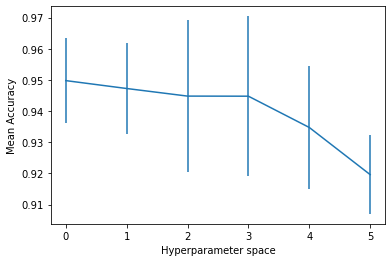

In [11]:
# Let's plot these model accuracys with the interval of performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Accuracy')

plt.xlabel('Hyperparameter space')

- Here we see the best performing model is the first one at hyper parameter space=0, and the next one is at hyperparameter space 1, with a similar performance

In [13]:
# let's get the predictions
train_preds = search.predict(X_train)
test_preds = search.predict(X_test)

print('Train Accuracy: {:.4f}'.format(accuracy_score(y_train, train_preds)))
print('Test Accuracy: {:.4f}'.format(accuracy_score(y_test, test_preds)))

Train Accuracy: 0.9623
Test Accuracy: 0.9532


Notice that the accuracy of the Test set (not used in training model) falls within the expected interval of accuracy of our best performing model (at hyperparameter space=0 above)

### 2. Repeated Kfold cross validation

- Very similar approach to doing kfold cross validation

In [14]:
# Logistic Regression
logit = LogisticRegression(
    penalty='l2', C=1, solver='liblinear', random_state=4, max_iter=10000) #these initial parameters dont matter too much as we'll be modifying them with grid search

# hyperparameter space - contains different parameters we want to test
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[0.1, 1, 10],
)

# K-fold cross-validation
rkf = RepeatedKFold(n_splits=5, 
                   n_repeats=10, 
                   random_state=4,
                  )


# search
clf = GridSearchCV(
    logit,
    param_grid,
    scoring='accuracy',
    cv=rkf, #repeated k-fold
    refit=True, #refits best model to entire dataset
)

# By fitting with grid search, it will build models with all the possible combinations of parameters in the parameter space
search = clf.fit(X_train, y_train)

# best hyperparameters
search.best_params_

{'C': 10, 'penalty': 'l1'}

It's interesting this model chooses the same penalisation constant as kfold, but chooses the ridge regularization over lasso (previous best model)

In [15]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(results.shape)
results

(6, 3)


,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'penalty': 'l1'}",0.922820,0.022496
1,"{'C': 0.1, 'penalty': 'l2'}",0.932896,0.021612
2,"{'C': 1, 'penalty': 'l1'}",0.948497,0.021488
3,"{'C': 1, 'penalty': 'l2'}",0.945718,0.022986
4,"{'C': 10, 'penalty': 'l1'}",0.955025,0.023470
5,"{'C': 10, 'penalty': 'l2'}",0.951509,0.023983


- again, when c=10 and penalty is either l1 or L2, the performances are very similar. So in reality, it wouldn't matter whether we choose ridge or lasso when c=10.

Text(0.5, 0, 'Hyperparameter space')

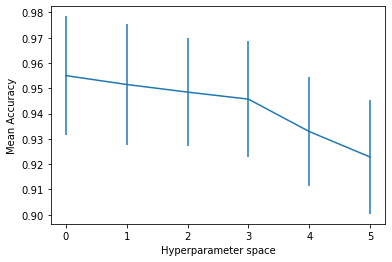

In [16]:
# Let's plot these model accuracys with the interval of performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Accuracy')

plt.xlabel('Hyperparameter space')

In [17]:
# let's get the predictions
train_preds = search.predict(X_train)
test_preds = search.predict(X_test)

print('Train Accuracy: {:.4f}'.format(accuracy_score(y_train, train_preds)))
print('Test Accuracy: {:.4f}'.format(accuracy_score(y_test, test_preds)))

Train Accuracy: 0.9749
Test Accuracy: 0.9708


- WOW! First, both train and test performance using repeated Kfold is much higher than simply using kfold. Not we've used the same hyper paramter space for both cross validation schemes, the only change has been the cross validation scheme
- Notice, the test accurachy falls within the expected interval of our chosen model

### 3. Stratified Cross validation

In [20]:
# Logistic Regression
logit = LogisticRegression(
    penalty='l2', C=1, solver='liblinear', random_state=4, max_iter=10000) #these initial parameters dont matter too much as we'll be modifying them with grid search

# hyperparameter space - contains different parameters we want to test
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[0.1, 1, 10],
)

# K-fold cross-validation
skf = StratifiedKFold(n_splits=5, 
                   shuffle=True, 
                   random_state=4,
                  )


# search
clf = GridSearchCV(
    logit,
    param_grid,
    scoring='accuracy',
    cv=skf, #stratified k-fold
    refit=True, #refits best model to entire dataset
)

# By fitting with grid search, it will build models with all the possible combinations of parameters in the parameter space
search = clf.fit(X_train, y_train)

# best hyperparameters
search.best_params_

{'C': 10, 'penalty': 'l2'}

In [21]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(results.shape)
results

(6, 3)


,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'penalty': 'l1'}",0.927025,0.020516
1,"{'C': 0.1, 'penalty': 'l2'}",0.926994,0.027246
2,"{'C': 1, 'penalty': 'l1'}",0.949652,0.026659
3,"{'C': 1, 'penalty': 'l2'}",0.944620,0.023649
4,"{'C': 10, 'penalty': 'l1'}",0.947184,0.021802
5,"{'C': 10, 'penalty': 'l2'}",0.952152,0.021933


Text(0.5, 0, 'Hyperparameter space')

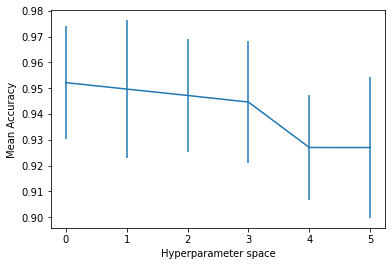

In [22]:
# Let's plot these model accuracys with the interval of performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Accuracy')

plt.xlabel('Hyperparameter space')

In [23]:
# let's get the predictions
train_preds = search.predict(X_train)
test_preds = search.predict(X_test)

print('Train Accuracy: {:.4f}'.format(accuracy_score(y_train, train_preds)))
print('Test Accuracy: {:.4f}'.format(accuracy_score(y_test, test_preds)))

Train Accuracy: 0.9623
Test Accuracy: 0.9532
